In [3]:
from fastai.data.all import *
from fastai.vision.all import *
from fastai.data.transforms import get_image_files
import PIL
import torch
import numpy as np
import os 

In [4]:
DATA_PATH = 'clean'
DATA_PATH_X = 'clean/x-data'
DATA_PATH_Y = 'clean/y-data'
CODES_PATH = "clean/codes.txt"
BATCH_SIZE = 4
IMG_SIZE = (128)

In [5]:
x_files = get_image_files(DATA_PATH_X)
y_files = get_image_files(DATA_PATH_Y)

In [6]:
def open_image(fname, size=IMG_SIZE):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    gray_img = PIL.ImageOps.grayscale(img)
    return torch.Tensor(np.array(gray_img))

def label_func(fname):
    path_y = "clean/y-data/"
    base_name_y = os.path.basename(fname)
    fname_y = os.path.join(path_y, base_name_y)
    return open_image(fname_y, size=(120))

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, ImageBlock),
    get_items=get_image_files,
    get_x = open_image,
    get_y = label_func,
    )

In [9]:
dls = dblock.dataloaders(
                    DATA_PATH_X, valid_pct=0.2, seed=11, bs=BATCH_SIZE, 
                    batch_tfms=[ 
                    Normalize.from_stats(*imagenet_stats)]
                    )

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


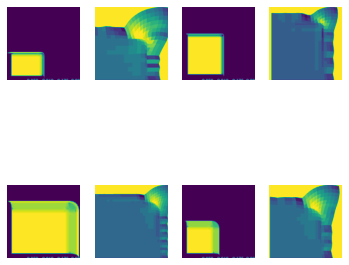

In [10]:
dls.show_batch(figsize=(6,6))

## Model

In [11]:
class LSNet(torch.nn.Module):
    def __init__(self):
        # call the parent constructor
        super(LSNet, self).__init__()
        self.conv_part = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.deconv_part = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(size=IMG_SIZE, mode='bilinear'),
        )
    def forward(self, x):
        x = self.conv_part(x)
        x = self.deconv_part(x)
        return x

In [12]:
model = LSNet()

In [13]:
input_test = torch.rand(20, 1, 128, 128)
print(input_test.shape)
model(input_test).shape

torch.Size([20, 1, 128, 128])


torch.Size([20, 1, 120, 120])

In [16]:
opt = ranger
metric = DiceMulti
# learn = Learner(dls, model, loss_func=torch.nn.MSELoss, metrics=metric, opt_func=opt)
learn = Learner(dls, model, loss_func=torch.nn.MSELoss)

In [17]:
learn.summary()

LSNet (Input shape: 4 x 1 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 32 x 31 x 31    
Conv2d                                    3904       True      
ReLU                                                           
____________________________________________________________________________
                     4 x 32 x 15 x 15    
MaxPool2d                                                      
____________________________________________________________________________
                     4 x 64 x 15 x 15    
Conv2d                                    51264      True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 7 x 7      
MaxPool2d                                                      
____________________________________________________________________________
                     4 x 128 x 7 x 7 

In [18]:
learn.lr_find()

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
learn.fit(2, 0.06)

In [ ]:
# def fit(epochs=1):
#     learn = Learner(dls, cnn(), loss_func=F.cross_entropy,
#                     metrics=metric)
#     learn.fit(epochs, 0.06)
#     return learn